# Overview


This notebook describes the different stages to build up different deep learning models trained over the dataset called **ISOT** by using pretrained **Word2Vec** and **Glove** Embeddings, for the automatic fake news detection

List of Deep Learning algorithms included 
- 1D CNN
- LSTM
- BiLSTM



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
import bert
from tensorflow.keras.models import  Model
from tqdm import tqdm
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate,BatchNormalization,GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.backend import clear_session



pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-07-08 21:34:26.066068: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-08 21:34:26.071022: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-08 21:34:26.071037: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the ISOT Full Dataset  -- After combined fake and real news  in the previous notebook   "ISOT_ML_Classifiers_TfiDF_Tokeniser"

In [2]:
isot_full_df = pd.read_csv("Updated//ISOT_Combined_FullData.csv")

***

## 2. Text Preprocessing


#### Remove the null values

In [3]:
df = isot_full_df[isot_full_df['fulltext'].notna()]

#### Shuffling the rows

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

#### Clean data using the built in cleaner function from  gensim library

In [7]:
# Clean data using the built in cleaner in gensim
df['cleantext'] = df['fulltext'].apply(lambda x: gensim.utils.simple_preprocess(x))

***

## 3. Model Training and Evaluation

### Splitting dataset into Features and Class labels

In [8]:
X=df['cleantext']
y=df['class']

#### Train and Test Split

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,stratify=y, random_state=0)

Since we need to pad  the sentences before feed to the model, For this, we need to find the maximum lenght of any document.

In [10]:
maxi=-1
for i,sent in enumerate(df['cleantext']):
    if(len(sent)>maxi):
        maxi=len(sent)
print(maxi)

7912


In [11]:
print("Maximum Length of the sequence : ",maxi)

Maximum Length of the sequence :  7912


#### Now we intialise Keras Tokeniser and fit on training set

In [12]:
tokenzr = Tokenizer()

In [13]:
tokenzr.fit_on_texts(X_train)
vocab_size = len(tokenzr.word_index) + 1


#### Encode  texts to sequence format for both training set and test set 

In [14]:
encd_train = tokenzr.texts_to_sequences(X_train)
encd_test = tokenzr.texts_to_sequences(X_test)

##### Hyperparameter Configuration Setting for the model training

In [15]:
print(len(tokenzr.word_index))

103042


In [16]:
maxi=2000  # max lenght of a review
vocab_size = len(tokenzr.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

**Pad both training and test encoded data to maximum length variable value**

In [17]:
pad_train= pad_sequences(encd_train, maxlen=maxi, padding='post')
pad_train.shape   

(30616, 2000)

In [18]:
pad_test= pad_sequences(encd_test, maxlen=maxi, padding='post')
pad_test.shape

(7654, 2000)

####  User defined helper functions to plot training and testing accuracy of the trained model

This function is using to save the loss and accuracy metrics of the training and test sets from the given input parameter which is a keras history callback object obtained during the model traning

In [20]:
import matplotlib.pyplot as plt
 
def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    


#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [21]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

## Feature Extractions using pretrained Word2Vec model

##### Load the  pretrained model

In [22]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#### After downloading it, you can load it as follows

In [23]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [24]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model_pretrained = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 18.1 s, sys: 1.31 s, total: 19.4 s
Wall time: 19.6 s
done loading Word2Vec


#### Then inspect the model by getting the list of index of key values from the pretrained model

In [26]:
# total numberof extracted words.
word2vec_vocab=w2v_model_pretrained.index_to_key
print("The total number of words are : ",len(word2vec_vocab))

The total number of words are :  3000000


In [27]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### Finding out the number of key value pairs of  vocabulary count and save those in a dictionary

In [28]:
word_vec_dict_pre={}
for word in word2vec_vocab:
    word_vec_dict_pre[word]=w2v_model_pretrained.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict_pre)) # should come equal to vocab size
  

The no of key-value pairs :  3000000


#### Creation of Embedding matrix which is a list of all words and their corresponding embeddings

In [30]:
# now creating the embedding matrix
embedded_matrix_2=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenzr.word_index.items():
    embedded_vec=word_vec_dict_pre.get(word)
    if embedded_vec is not None:  # word is in the vocabulary learned by the w2v model
        embedded_matrix_2[i]=embedded_vec

***
## Model Training

### Using 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [31]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//isot_dl_word2vec//model_ISOT_CNN_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [32]:
clear_session()
cnn_model=Sequential()
cnn_model.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model.summary())

2022-07-08 21:35:57.320918: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-08 21:35:57.321318: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-08 21:35:57.321625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30912900  
                                                                 
 conv1d (Conv1D)             (None, 1998, 128)         115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127872)            0         
                                                                 
 dense (Dense)               (None, 128)               16367744  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

#### Model Training

In [33]:
history_cnn_word2vec=cnn_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1492 - accuracy: 0.9344WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2acc13eb3840> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

Save the model callback history details to csv 

In [ ]:
hist_df = pd.DataFrame(history_cnn_word2vec.history) 
hist_df.to_csv("outputs//isot_dl_word2vec//model_ISOT_CNN_WORD2VEC_history.csv",index=False)


#### Load the trained model

In [36]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//isot_dl_word2vec//model_ISOT_CNN_WORD2VEC_PRETRAINED.h5')

#### Predict the test data and calculate the metrics

In [37]:
y_pred=cnn_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 8s 31ms/step


In [38]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9815782597334727
precision = 0.9973269973269974
recall = 0.9621776504297994
f1score = 0.9794370716056584
[[4155    9]
 [ 132 3358]]
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      4164
           1       1.00      0.96      0.98      3490

    accuracy                           0.98      7654
   macro avg       0.98      0.98      0.98      7654
weighted avg       0.98      0.98      0.98      7654



**Save the classification report to csv**

In [39]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_word2vec//model_ISOT_CNN_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.969209,0.997839,0.983316,4164.000000
1,0.997327,0.962178,0.979437,3490.000000
accuracy,0.981578,0.981578,0.981578,0.981578
macro avg,0.983268,0.980008,0.981376,7654.000000
weighted avg,0.982030,0.981578,0.981547,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

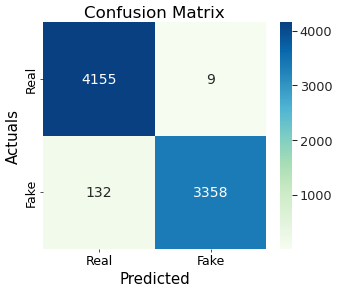

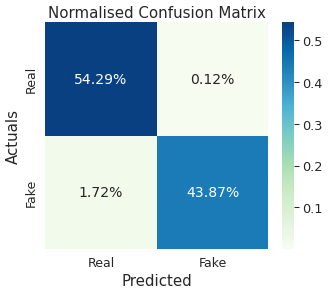

In [41]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_word2vec//isot_cnn_w2v_cmtrx.png"
path2="outputs//isot_dl_word2vec//isot_cnn_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9983260035514832
Validation Accuracy : 0.9810581207275392
Precision : 0.9973269973269974
Recall : 0.9621776504297994
F1 Score : 0.9794370716056584


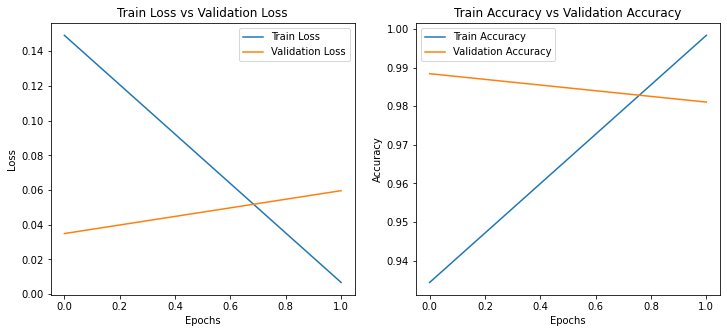

In [35]:
hist_df = pd.read_csv("outputs//isot_dl_word2vec//model_ISOT_CNN_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")

### Using LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [42]:
# Model Checkpoint and EarlyStopping
filepath_lstm = "outputs//isot_dl_word2vec//model_ISOT_LSTM_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint_lstm = ModelCheckpoint(filepath_lstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_lstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_lstm = [checkpoint_lstm,es_lstm]

#### Build the model 

In [43]:
from keras.initializers import Constant
lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
lstm_model.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dropout(0.3))
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 300)         30912900  
                                                                 
 lstm (LSTM)                 (None, 2000, 128)         219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [44]:
clear_session()

#### Model Training

In [45]:
history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_lstm) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.2672 - accuracy: 0.9038WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2acc13c78ae8> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

Save the model callback history details to csv 

In [ ]:
hist_df = pd.DataFrame(history_lstm_word2vec.history) 
hist_df.to_csv("outputs//isot_dl_word2vec//model_ISOT_LSTM_WORD2VEC_history.csv",index=False)

#### Load the model

In [50]:
from tensorflow.keras.models import load_model
lstm_model = load_model('outputs//isot_dl_word2vec//model_ISOT_LSTM_WORD2VEC_PRETRAINED.h5')

#### Predict the test data and calculate the metrics

In [51]:
y_pred=lstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 196s 817ms/step


In [52]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9881107917428795
precision = 0.987661406025825
recall = 0.9862464183381089
f1score = 0.9869534050179212
[[4121   43]
 [  48 3442]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4164
           1       0.99      0.99      0.99      3490

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



**Save the classification report to csv**

In [53]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_word2vec//model_ISOT_LSTM_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.988486,0.989673,0.989080,4164.000000
1,0.987661,0.986246,0.986953,3490.000000
accuracy,0.988111,0.988111,0.988111,0.988111
macro avg,0.988074,0.987960,0.988016,7654.000000
weighted avg,0.988110,0.988111,0.988110,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

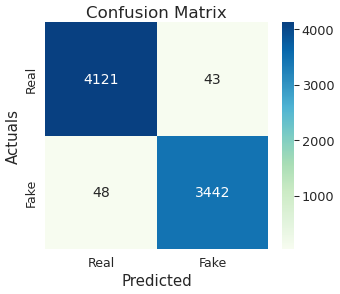

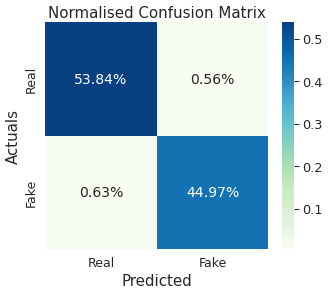

In [55]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_word2vec//isot_lstm_w2v_cmtrx.png"
path2="outputs//isot_dl_word2vec//isot_lstm_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

240/240 [==============================] - 192s 801ms/step
Training Accuracy : 0.9823207855224609
Validation Accuracy : 0.9870999455451965
Precision : 0.987661406025825
Recall : 0.9862464183381089
F1 Score : 0.9869534050179212
LSTM Completed


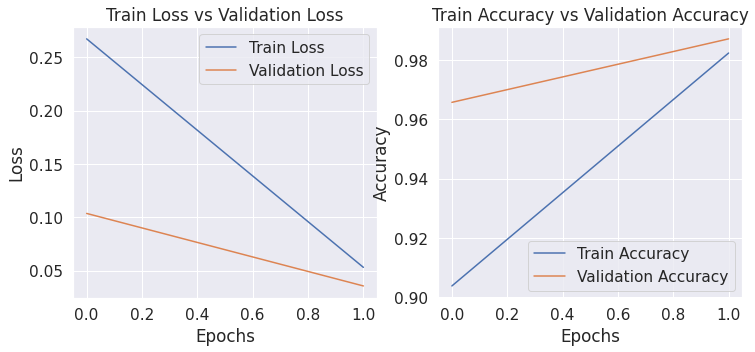

In [49]:
plot_loss_and_acc_from_hist2(hist_df)
print("LSTM Completed")


### Using BiLSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [57]:
# Model Checkpoint and EarlyStopping
filepath_bilstm = "outputs//isot_dl_word2vec//model_ISOT_BiLSTM_WORD2VEC_PRETRAINED.h5" # Location to get the model
checkpoint_bilstm = ModelCheckpoint(filepath_bilstm, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm = [checkpoint_bilstm,es_bilstm]

#### Build the model 

In [58]:
from keras.initializers import Constant
bilstm_model=Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
bilstm_model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model.add(GlobalMaxPooling1D())
bilstm_model.add(Dropout(0.3))
bilstm_model.add(Dense(64,activation='relu'))
bilstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30912900  
                                                                 
 bidirectional (Bidirectiona  (None, 2000, 256)        439296    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dense_1 (Dense)             (None, 1)                 6

#### Model Training

In [59]:
clear_session()
history_bilstm_word2vec=bilstm_model.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.1369 - accuracy: 0.9441WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ad163c260d0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

Save the model callback history details to csv 

In [ ]:
hist_df = pd.DataFrame(history_bilstm_word2vec.history) 
hist_df.to_csv("outputs//isot_dl_word2vec//model_ISOT_BILSTM_WORD2VEC_history.csv",index=False)

#### Load the model

In [61]:
from tensorflow.keras.models import load_model
bilstm_model = load_model('outputs//isot_dl_word2vec//model_ISOT_BiLSTM_WORD2VEC_PRETRAINED.h5')

#### Predict the test data and calculate the metrics

In [62]:
y_pred=bilstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 230s 955ms/step


In [63]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9930755160700288
precision = 0.9928305133352452
recall = 0.9919770773638968
f1score = 0.9924036118675649
[[4139   25]
 [  28 3462]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4164
           1       0.99      0.99      0.99      3490

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



**Save the classification report to csv**

In [64]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_word2vec//model_ISOT_BILSTM_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.993281,0.993996,0.993638,4164.000000
1,0.992831,0.991977,0.992404,3490.000000
accuracy,0.993076,0.993076,0.993076,0.993076
macro avg,0.993056,0.992987,0.993021,7654.000000
weighted avg,0.993075,0.993076,0.993075,7654.000000


**Plot confusion matrix using the user defined functions created earlier**

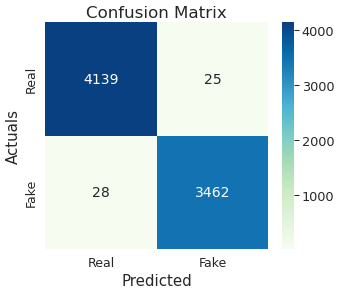

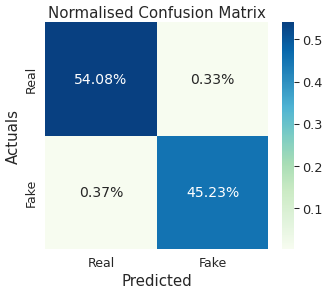

In [66]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_word2vec//isot_bilstm_w2v_cmtrx.png"
path2="outputs//isot_dl_word2vec//isot_bilstm_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 232s 963ms/step
Training Accuracy : 0.9934264421463013
Validation Accuracy : 0.9934683442115784
Precision : 0.9928305133352452
Recall : 0.9919770773638968
F1 Score : 0.9924036118675649


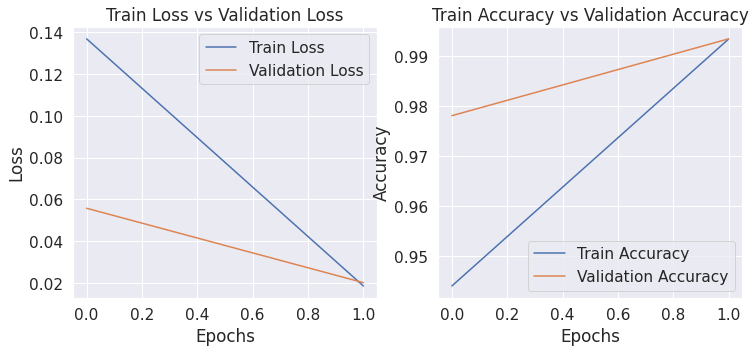

In [60]:
plot_loss_and_acc_from_hist2(hist_df)
#print("BILSTM Completed")


## Feature Extraction Pretrained Glove

##### Download the pretrained zip file

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

#### Load the downloaded the 300 dimension Glove pretrained model "glove.6B.300d.txt" in a path and convert to word2vec format",

In [67]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [68]:
glove_path = 'Embeddings//glove.6B.300d.txt'

In [69]:
import os
glove_embeddings_index = {}
f = open(os.path.join(glove_path), encoding="utf8")

#### Finding out the number of key value pairs of  vocabulary count and save those in a dictionary

In [70]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

In [71]:
print('Total %s word vectors in Glove.' % len(glove_embeddings_index))


Total 400000 word vectors in Glove.


#### Creation of Embedding matrix which is a list of all words and their corresponding embeddings

In [72]:
embedding_gmatrix = np.random.random((len(tokenzr.word_index) + 1, embed_dim))
for word, i in tokenzr.word_index.items():
    embedding_gvector = glove_embeddings_index.get(word)
    if embedding_gvector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_gmatrix[i] = embedding_gvector

***

### 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [73]:
filepath = "outputs//isot_dl_glove//model_ISOT_CNN_GLOVE_V1.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [74]:
warnings.filterwarnings('ignore')
cnn_model_g=Sequential()
cnn_model_g.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model_g.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Flatten())
cnn_model_g.add(Dense(128, activation='relu'))
cnn_model_g.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model_g.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2000, 300)         30912900  
                                                                 
 conv1d (Conv1D)             (None, 1998, 128)         115328    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 999, 128)         0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 127872)            0         
                                                                 
 dense (Dense)               (None, 128)               16367744  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                        

#### Train the model

In [75]:
history_cnn_glove=cnn_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
192/192 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.8941WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x2ad3a6fe8598> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and

Save the model callback history details to csv 

In [ ]:
hist_df = pd.DataFrame(history_cnn_glove.history) 
hist_df.to_csv("outputs//isot_dl_glove//model_ISOT_CNN_GLOVE_history.csv",index=False)


#### Load the model

In [77]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//isot_dl_glove//model_ISOT_CNN_GLOVE_V1.h5')

#### Predict the test data and calculate the metrics

In [78]:
y_pred=cnn_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.4).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 7s 31ms/step


In [79]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.9911157564672067
precision = 0.9936526255049047
recall = 0.9868194842406877
f1score = 0.9902242668200115
[[4142   22]
 [  46 3444]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4164
           1       0.99      0.99      0.99      3490

    accuracy                           0.99      7654
   macro avg       0.99      0.99      0.99      7654
weighted avg       0.99      0.99      0.99      7654



#### Save the classification report to csv

In [80]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_glove//model_ISOT_CNN_GLOVE_clasifctnrpt.csv")

**Plot confusion matrix using the user defined functions created earlier**

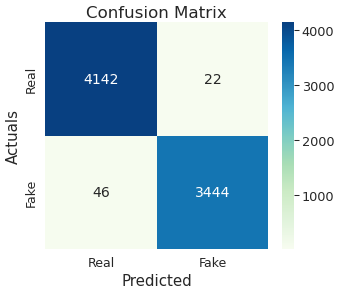

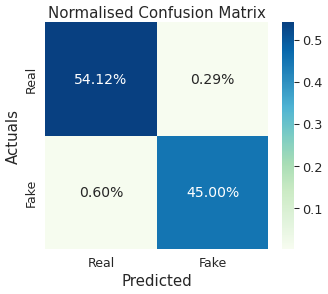

In [82]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_glove//isot_cnn_cmtrx.png"
path2="outputs//isot_dl_glove//isot_cnn_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
240/240 [==============================] - 8s 31ms/step
Training Accuracy : 0.997713565826416
Validation Accuracy : 0.988406240940094
Precision : 0.9942146369684698
Recall : 0.9848137535816619
F1 Score : 0.9894918669929466


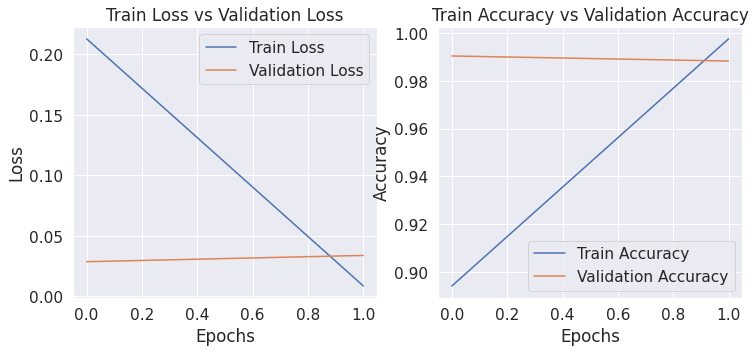

In [76]:
plot_loss_and_acc_from_hist2(hist_df)
#print("CNN Completed")


### Using LSTM

In [83]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//isot_dl_glove//model_ISOT_LSTM_GLOVE_PRETRAINED_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [84]:
from keras.initializers import Constant
lstm_model_g=Sequential()
lstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
lstm_model_g.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model_g.add(GlobalMaxPooling1D())
lstm_model_g.add(Dropout(0.3))
lstm_model_g.add(Dense(64,activation='relu'))
lstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
lstm_model_g.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2000, 300)         30912900  
                                                                 
 lstm (LSTM)                 (None, 2000, 128)         219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                      

In [85]:
clear_session()

#### Model Training

In [ ]:
history_lstm_glove=lstm_model_g.fit(pad_train,y_train,epochs=3,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

Epoch 1/3
  1/192 [..............................] - ETA: 17:09 - loss: 0.0236 - accuracy: 0.9922

#### Save the model callback history details to csv 

In [ ]:
hist_df = pd.DataFrame(history_lstm_glove.history) 
hist_df.to_csv("outputs//isot_dl_glove//model_ISOT_LSTM_GLOVE_history.csv",index=False)



#### Load the model and Predict the test data and calculate the metrics

In [ ]:
from tensorflow.keras.models import load_model
lstm_model_g = load_model('outputs//isot_dl_glove//model_ISOT_LSTM_GLOVE_PRETRAINED_V2.h5')


y_pred=lstm_model_g.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.4).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

In [ ]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

#### Save the classification report to csv

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_glove//model_ISOT_LSTM_GLOVE_clasifctnrpt.csv")

**Plot confusion matrix using the user defined functions created earlier**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_glove//isot_lstm_cmtrx.png"
path2="outputs//isot_dl_glove//isot_lstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

In [ ]:

plot_loss_and_acc_from_hist2(hist_df)
#print("LSTM Completed")

### Using BiLSTM

In [ ]:
# Model Checkpoint and EarlyStopping
filepath_bilstm_g = "outputs//isot_dl_glove//model_ISOT_BILSTM_GLOVE_PRETRAINED_V2.h5" # Location to get the model
checkpoint_bilstm_g = ModelCheckpoint(filepath_bilstm_g, monitor='loss', verbose=1, save_best_only=True, mode='min')
es_bilstm_g = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list_bilstm_g = [checkpoint_bilstm_g,es_bilstm_g]

#### Build the model

In [ ]:
from keras.initializers import Constant
bilstm_model_g=Sequential()
bilstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
bilstm_model_g.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model_g.add(GlobalMaxPooling1D())
bilstm_model_g.add(Dropout(0.3))
bilstm_model_g.add(Dense(64,activation='relu'))
bilstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
bilstm_model_g.summary()

In [ ]:
clear_session()

#### Model Training

In [ ]:
history_bilstm_glove=bilstm_model_g.fit(pad_train,y_train,epochs=3,batch_size=128,validation_split=0.2,shuffle=True, callbacks=callbacks_list_bilstm_g) 

#### Save the model callback history details to csv 

In [ ]:
hist_df = pd.DataFrame(history_bilstm_glove.history) 
hist_df.to_csv("outputs//isot_dl_glove//model_ISOT_BILSTM_GLOVE_history.csv",index=False)


#### Load the model and Predict the test data and calculate the metrics

In [ ]:
from tensorflow.keras.models import load_model
bilstm_model_g = load_model('outputs//isot_dl_glove//model_ISOT_BILSTM_GLOVE_PRETRAINED_V2.h5')


y_pred=bilstm_model_g.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

In [ ]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

#### Save the classification report to csv

In [ ]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//isot_dl_glove//model_ISOT_BILSTM_GLOVE_clasifctnrpt.csv")

**Plot confusion matrix using the user defined functions created earlier**

In [ ]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//isot_dl_glove//isot_bilstm_cmtrx.png"
path2="outputs//isot_dl_glove//isot_bilstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

In [ ]:

plot_loss_and_acc_from_hist2(hist_df)
#print("BiLSTM Completed")